In [ ]:
# Append src directory to path
import sys
sys.path.append('C:\\Users\\kingt\\Dropbox\\Programming\\NeuralSimV3\\NeuroSimV3\\python\\src')

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt


from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation
import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter

In [3]:
dt = 0.1

In [4]:
n = 100       # total neurons
k = 4        # each neuron initially connects to k neighbors (k must be even)
p = 0.85     # rewiring probability

# 1. Generate an undirected WS graph
G_undirected = nx.newman_watts_strogatz_graph(n, k, p)
# G_undirected = nx.watts_strogatz_graph(n, k, p)


In [5]:
# Parameters
N   = 50       # total number of neurons
m   = 4          # each new node attaches to m existing nodes (so average degree ≈ 2m)
p_T = 0.3        # “triad‐formation probability”: higher → more triangles → higher clustering

# Generate an undirected powerlaw‐cluster graph
G_undirected = nx.powerlaw_cluster_graph(n=N, m=m, p=p_T)

In [6]:
# 2. Convert to directed by randomly orienting each edge
G_directed = nx.DiGraph()
G_directed.add_nodes_from(G_undirected.nodes())
for u, v in G_undirected.edges():
    if random.random() < 0.50:
        G_directed.add_edge(u, v)
    else:
        G_directed.add_edge(v, u)

# Ensure every node has at least 1 out edge
for node in G_directed.nodes():
    if G_directed.out_degree(node) == 0:
        # Pick a random target (not self, not already connected)
        possible_targets = [n for n in G_directed.nodes() if n != node and not G_directed.has_edge(node, n)]
        if possible_targets:
            target = random.choice(possible_targets)
            G_directed.add_edge(node, target)

In [7]:
G_undirected = G_directed.to_undirected()

print(smallworld.sigma(G_undirected, 10, 1))
print(smallworld.omega(G_undirected, 2, 4))

1.0338863892013497
0.007972440944881809


Nodes: 50, Edges: 181
In-degree dist: Counter({3: 13, 2: 12, 5: 6, 4: 6, 6: 4, 1: 4, 7: 2, 9: 1, 13: 1, 0: 1})
Out-degree dist: Counter({2: 17, 3: 11, 1: 8, 5: 3, 4: 3, 10: 2, 7: 2, 17: 1, 9: 1, 13: 1, 6: 1})
Total-degree dist: Counter({4: 13, 5: 13, 7: 5, 6: 5, 9: 4, 8: 3, 23: 2, 19: 1, 14: 1, 18: 1, 13: 1, 10: 1})


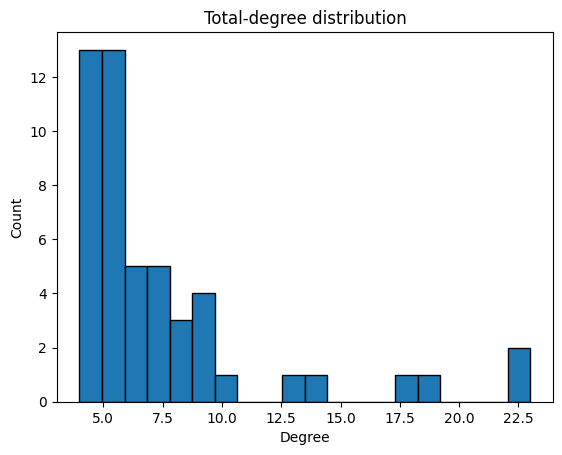

In [8]:
# --- 1. Basic stats
n = G_directed.number_of_nodes()
m = G_directed.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")

# --- 2. Degree stats
in_deg  = dict(G_directed.in_degree())
out_deg = dict(G_directed.out_degree())
tot_deg = {i: in_deg.get(i,0) + out_deg.get(i,0) for i in G_directed.nodes}

# Degree distributions
print("In-degree dist:", Counter(in_deg.values()))
print("Out-degree dist:", Counter(out_deg.values()))
print("Total-degree dist:", Counter(tot_deg.values()))

# Optional: histogram of total degree
plt.hist(list(tot_deg.values()), bins=20, edgecolor='black')
plt.title("Total-degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [9]:
html_file = "connectome1.html" 
notebook: bool = True
colour_scheme: str = "layer" 
node_size_scale: float = 2.0

try:
    from pyvis.network import Network
except ImportError:
    raise ImportError("pyvis not found - install with `pip install pyvis`")

net = Network(height="750px", width="100%", directed=True,
            notebook=notebook, bgcolor="#ffffff")
net.repulsion()

# Compute each node's total degree
deg_in  = dict(G_directed.in_degree())
deg_out = dict(G_directed.out_degree())
total_deg = {n: deg_in.get(n, 0) + deg_out.get(n, 0) for n in G_directed.nodes}

# -------- nodes (with colours, tooltips, and dynamic sizes) ----------
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

for n in G_directed.nodes:
    # Build hover title
    title = (
        f"Neuron {n}<br/>"
        f"InDegree: {deg_in.get(n, 0)}<br/>OutDegree: {deg_out.get(n, 0)}"
    )

    # Size = (total_degree + 1) * node_size_scale
    size = (total_deg.get(n, 0) + 1) * node_size_scale

    net.add_node(n,
                label=str(n),
                title=title,
                size=size)

# -------- edges ------------
for u, v, data in G_directed.edges(data=True):
    w = data.get("weight", None)
    syn_idx = data.get("synapse_index", None)
    dist = data.get("distance", None)  # anatomical distance
    # If distance is missing or zero, fallback to a small positive default
    length = float(dist) if (dist is not None and dist > 0.0) else 50.0

    # Edge thickness ∝ |weight|
    thickness = abs(w) if w is not None else 1.0

    hover_txt = []
    if syn_idx is not None:
        hover_txt.append(f"synapse_index = {syn_idx}")
    if w is not None:
        hover_txt.append(f"weight = {w:.3f}")
    if dist is not None:
        hover_txt.append(f"distance = {dist:.2f}")

    net.add_edge(
        u,
        v,
        value   = thickness * 0.1,         # edge thickness ∝ |weight|
        title   = "<br/>".join(hover_txt),
        length  = length * 20              # rest‐length ≈ anatomical distance
    )

net.show(html_file)

connectome1.html


In [10]:
import networkx as nx
from networkx.algorithms import smallworld
from collections import Counter

# --- 1. Basic stats
n = G.number_of_nodes()
m = G.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")

# --- 2. Degree stats
in_deg  = dict(G.in_degree())
out_deg = dict(G.out_degree())
tot_deg = {i: in_deg.get(i,0) + out_deg.get(i,0) for i in G.nodes}

# Degree distributions
print("In-degree dist:", Counter(in_deg.values()))
print("Out-degree dist:", Counter(out_deg.values()))
print("Total-degree dist:", Counter(tot_deg.values()))

# Optional: histogram of total degree
plt.hist(list(tot_deg.values()), bins=20, edgecolor='black')
plt.title("Total-degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

# --- 3. Connectivity
wcc = list(nx.weakly_connected_components(G))
scc = list(nx.strongly_connected_components(G))
print(f"Weakly CCs: {len(wcc)}, Strongly CCs: {len(scc)}")

# Largest (weakly) connected subgraph for undirected metrics
Gu = G.to_undirected()
largest_cc = max(nx.connected_components(Gu), key=len)
G_cc = Gu.subgraph(largest_cc).copy()

print(f"Largest WCC size (nodes): {G_cc.number_of_nodes()}")
print(f"Largest WCC size (edges): {G_cc.number_of_edges()}")

# --- 4. Centralities (example: top 5 in‐degree and betweenness)
deg_cent_in  = nx.in_degree_centrality(G)
bw_cent      = nx.betweenness_centrality(G, k=None, normalized=True)  # expensive if k=None
cl_cent      = nx.closeness_centrality(G)

print("Top 5 by in-degree centrality:", sorted(deg_cent_in.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 by betweenness centrality:", sorted(bw_cent.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 by closeness centrality:", sorted(cl_cent.items(), key=lambda x: x[1], reverse=True)[:5])

# --- 5. Clustering & transitivity (undirected)
C_G = nx.average_clustering(G_cc)
T_G = nx.transitivity(G_cc)
print(f"Avg clustering (C_G): {C_G:.4f}, Transitivity: {T_G:.4f}")

# --- 6. Path lengths & diameter
L_G = nx.average_shortest_path_length(G_cc)
diam_G = nx.diameter(G_cc)
print(f"Avg shortest path (L_G): {L_G:.4f}, Diameter: {diam_G}")

# --- 7. Small-world comparison (undirected random G(n,m))
n_cc, m_cc = G_cc.number_of_nodes(), G_cc.number_of_edges()
R = nx.gnm_random_graph(n = n_cc, m = m_cc, seed=41)

C_R = nx.average_clustering(R)
L_R = nx.average_shortest_path_length(R)
sigma  = (C_G / C_R) / (L_G / L_R)
print("Random avg clustering (C_R):", round(C_R,4))
print("Random avg shortest path (L_R):", round(L_R,4))
print(f"Small-world coefficient σ = {sigma:.3f}")

# --- 8. Assortativity (directed)
r_in_in   = nx.degree_assortativity_coefficient(G, x='in',  y='in')
r_out_out = nx.degree_assortativity_coefficient(G, x='out', y='out')
print(f"In-in assortativity: {r_in_in:.4f}, Out-out assortativity: {r_out_out:.4f}")

# --- 9. Core decomposition (undirected)
core_nums = nx.core_number(Gu)
print("Top 5 core numbers:", sorted(core_nums.items(), key=lambda x: x[1], reverse=True)[:5])

# --- 10. Directed triangle count (3-cycles)
count_3 = 0
import itertools
for trio in itertools.combinations(G.nodes, 3):
    for perm in itertools.permutations(trio, 3):
        u,v,w = perm
        if G.has_edge(u, v) and G.has_edge(v, w) and G.has_edge(w, u):
            count_3 += 1
count_3 //= 6
print(f"Number of directed 3-cycles: {count_3}")


NameError: name 'G' is not defined